# QuTiP example: Vacuum Rabi oscillations in the Jaynes-Cummings model

J.R. Johansson and P.D. Nation

This ipython notebook demonstrates how to simulate the quantum vacuum rabi oscillations in the Jaynes-Cumming model, using QuTiP: The Quantum Toolbox in Python.

For more information about QuTiP see project web page: http://code.google.com/p/qutip/

In [1]:
import sys, os
sys.path.append(r"/Users/gkoolstra/Documents/Code")
from Common import common, kfit
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from qutip import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Introduction

The Jaynes-Cumming model is the simplest possible model of quantum mechanical light-matter interaction, describing a single two-level atom interacting with a single electromagnetic cavity mode. The Hamiltonian for this system is (in dipole interaction form)

$H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)$

or with the rotating-wave approximation

$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$

where $\omega_c$ and $\omega_a$ are the frequencies of the cavity and atom, respectively, and $g$ is the interaction strength.

### Problem parameters


Here we use units where $\hbar = 1$: 

Remember that for a two-level system the average occupation is 

$$\bar{n} = \sum_{n=0,1} n P_n = P_1 = \frac{e^{-\beta h f_0}}{1 + e^{-\beta h f_0}} = \frac{1}{1 + e^{\beta h f_0}}$$

And for a three level system it is: 

$$ \bar{n} = \sum_{n=0,1,2} n P_n = P_1 + 2 P_2 = \frac{e^{-\beta h f_0} + 2 e^{-\beta h (2f_0 + \alpha)}}{1 + e^{-\beta h f_0} + e^{-\beta h (2f_0+\alpha)}} = \frac{1 + e^{-\beta h (f_0 + \alpha)}}{1 + e^{\beta h f_0} + e^{-\beta h (f_0 + \alpha)}}$$

In [38]:
from scipy.constants import Boltzmann as kB, Planck as h

def two_level_nth(f0, T):
    return 1 / (1 + np.exp(h * f0 / (kB * T)))

def three_level_nth(f0, anharm, T):
    return (1 + np.exp(- h * (f0 + anharm) / (kB * T))) / (1 + np.exp(h * f0 / (kB * T)) + np.exp(- h * (f0 + anharm) / (kB * T)))

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
51it [00:00, 55.47it/s]


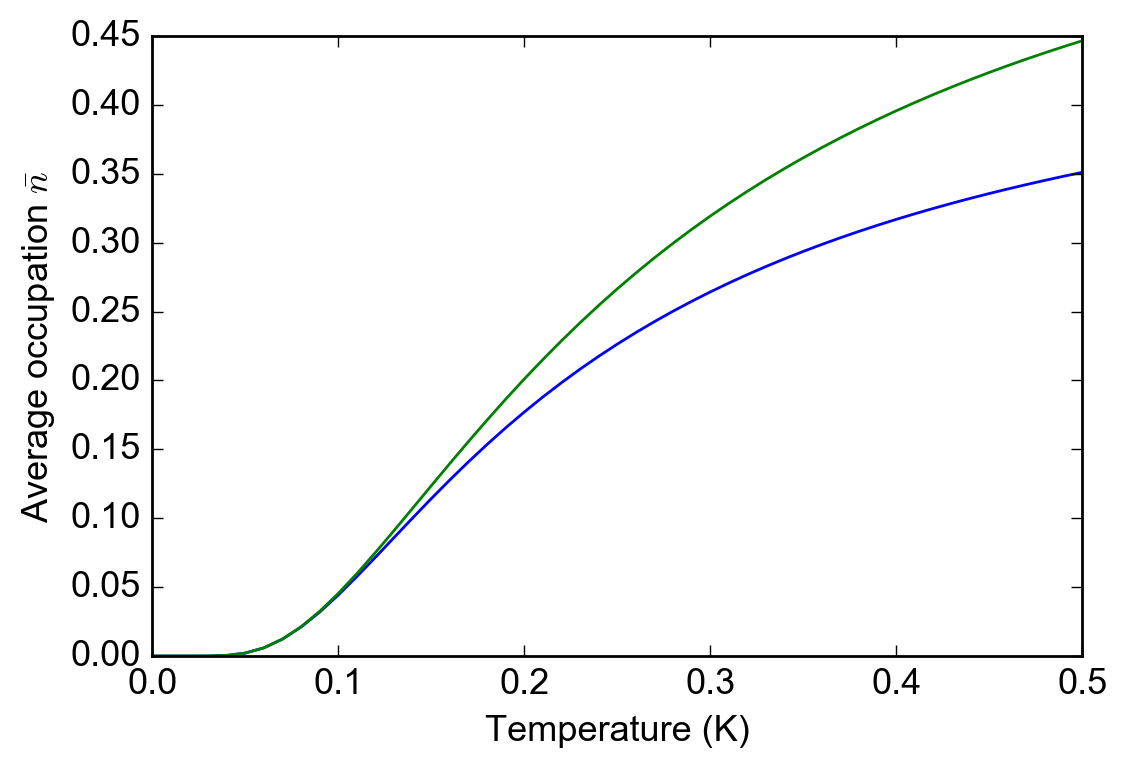

In [47]:
wc = 2 * np.pi * 6.40E9  # cavity frequency
wa = 2 * np.pi * 6.40E9  # atom frequency
g  = 2 * np.pi * 10E6  # coupling strength
kappa = 2 * np.pi * 0.4E6        # cavity dissipation rate
gamma = 2 * np.pi * 500E6           # atom dissipation rate
N = 15   # number of cavity fock states
Ts = np.linspace(0., 0.50, 51)
anharm = 1E9 # Units are Hz (don't include 2 pi)

# n_th_a = 1.0       # temperature in frequency units
use_rwa = True
do_plot = False

tlist = np.linspace(0, 10. * 1 / gamma , 100)

plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(Ts, two_level_nth(wc/(2*np.pi), Ts), label="2 level")
plt.plot(Ts, three_level_nth(wc/(2*np.pi), anharm, Ts), label="3 level")
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"Average occupation $\bar{n}$")

if do_plot:
    fig, ax = plt.subplots(figsize=(6., 4.))

n_ths = two_level_nth(wc/(2*np.pi), Ts) #three_level_nth(wc / (2 * np.pi), anharm, Ts) 
Gammas = np.zeros(len(n_ths))
    
for i, n_th_a in tqdm(enumerate(n_ths)):
    # intial state
    psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

    # operators
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))

    # Hamiltonian
    if use_rwa:
        H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    else:
        H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())

    c_op_list = []

    rate = gamma * (1 + n_th_a)
    if rate > 0.0:
#         print("Atom decay PRESENT.")
        c_op_list.append(np.sqrt(rate) * sm)

    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
#         print("Resonator photon decay PRESENT.")
        c_op_list.append(np.sqrt(rate) * a)

    rate = gamma * n_th_a
    if rate > 0.0:
#         print("Atom thermal excitation PRESENT.")
        c_op_list.append(np.sqrt(rate) * sm.dag())

    rate = kappa * n_th_a
    if rate > 0.0:
#         print("Resonator thermal excitation PRESENT.")
        c_op_list.append(np.sqrt(rate) * a.dag())

    # rate = gamma
    # if rate > 0.0:
    #     c_op_list.append(np.sqrt(rate) * sm)

    output = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a, sm.dag() * sm])
    P_cavity = output.expect[0]
    P_atom = output.expect[1]

    # Plotting
    if do_plot:
        common.configure_axes(13)
        ax.plot(tlist, P_cavity, label="Cavity")
        ax.plot(tlist, P_atom, label="Atom excited state")
        ax.legend(loc=0, prop={"size" : 10})
        ax.set_xlabel('Time')
        ax.set_ylabel('Occupation probability')
        ax.set_title('Vacuum Rabi oscillations');

    fr, ferr = kfit.fit_exp(tlist, P_atom, verbose=False)
    
    if do_plot:
        plt.plot(tlist, kfit.expfunc(tlist, *fr), '-r')
        plt.yscale("log")
        plt.ylim(1E-4, 1E0)
    
    Gammas[i] = 1 / (2 * np.pi * fr[2] * 1E6)

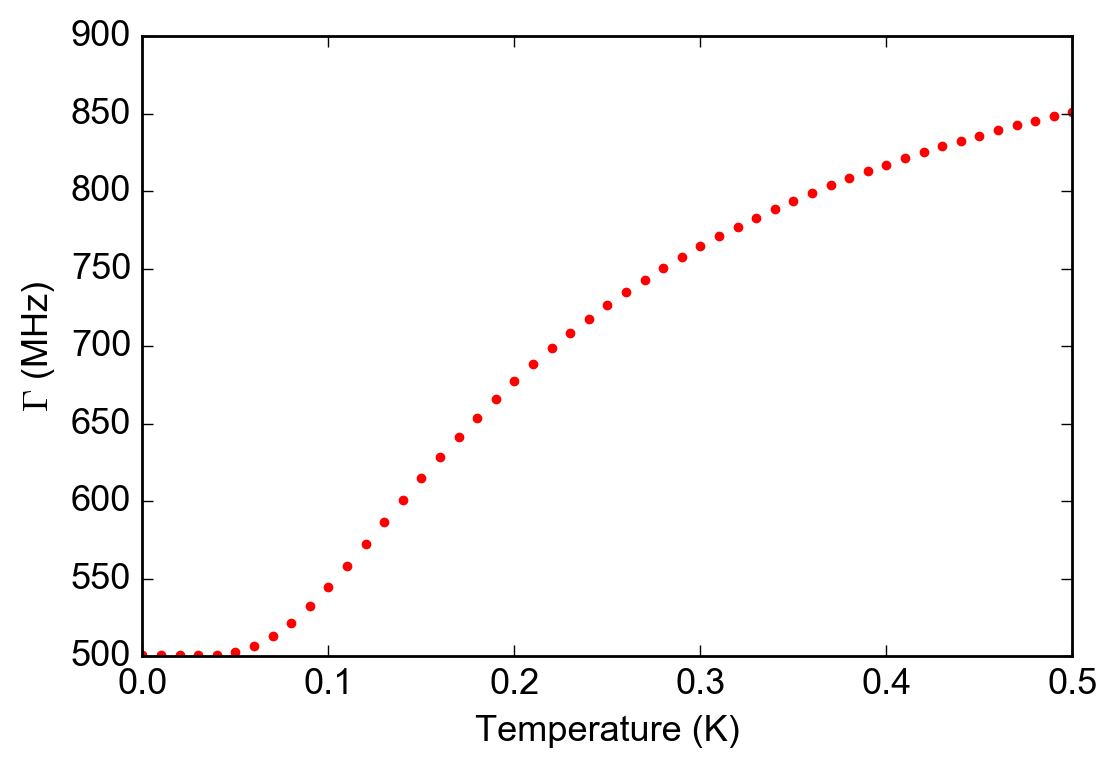

In [48]:
plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(Ts, Gammas, '.r')
plt.xlabel("Temperature (K)")
plt.ylabel(r"$\Gamma$ (MHz)")